In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Save the dataset to a CSV file
iris_df.to_csv('iris_dataset.csv', index=False)

print("Iris dataset downloaded successfully to 'iris_dataset.csv'")

Iris dataset downloaded successfully to 'iris_dataset.csv'


In [4]:
df = iris_df.loc[iris_df['target'] < 2].copy()
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [6]:
df['vector'] = df.apply(lambda row: np.array([row['sepal length (cm)'], row['sepal width (cm)'], row['petal length (cm)'], row['petal width (cm)']]), axis=1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,vector
0,5.1,3.5,1.4,0.2,0,"[5.1, 3.5, 1.4, 0.2]"
1,4.9,3.0,1.4,0.2,0,"[4.9, 3.0, 1.4, 0.2]"
2,4.7,3.2,1.3,0.2,0,"[4.7, 3.2, 1.3, 0.2]"
3,4.6,3.1,1.5,0.2,0,"[4.6, 3.1, 1.5, 0.2]"
4,5.0,3.6,1.4,0.2,0,"[5.0, 3.6, 1.4, 0.2]"
...,...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1,"[5.7, 3.0, 4.2, 1.2]"
96,5.7,2.9,4.2,1.3,1,"[5.7, 2.9, 4.2, 1.3]"
97,6.2,2.9,4.3,1.3,1,"[6.2, 2.9, 4.3, 1.3]"
98,5.1,2.5,3.0,1.1,1,"[5.1, 2.5, 3.0, 1.1]"


In [33]:
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate=0.5):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)  # Add dropout layer after first fully connected layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)  # Add dropout layer after second fully connected layer
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout to the output of the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout to the output of the second fully connected layer
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x

In [37]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BinaryClassifierModel:

    def __init__(self) -> None:
        self.dataset_train = None
        self.dataloader_train = None
        self.dataset_val = None
        self.dataloader_val = None
        pass

    
    
    def load_config(self, config):
        self.learning_rate = config.get('learning rate', 0.001)
        self.batch_size = config.get('batch size', 4)
        self.num_epochs = config.get('num epochs', 100)
        self.hidden_size1 = config.get('hidden size 1', 64)
        self.hidden_size2 = config.get('hidden size 2', 32)
        self.dropout_rate = config.get('dropout rate', 0.5)
        
    


    def load_data(self, X, y):
        self.input_size = len(X[0])
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return dataset, dataloader
    


    def load_train_data(self, X, y):
        self.dataset_train, self.dataloader_train = self.load_data(X, y)


    
    def load_val_data(self, X, y):
        self.dataset_val, self.dataloader_val = self.load_data(X, y)


    
    def create_new_model(self):
        self.model = BinaryClassifier(
            input_size=self.input_size,
            hidden_size1=self.hidden_size1,
            hidden_size2=self.hidden_size2,
            dropout_rate=self.dropout_rate,
        )



    def load_model(self, model):
        self.model = model



    def load_weights(self, weights_filepath):
        self.model.load_state_dict(torch.load(weights_filepath))



    def train(self):
        # Define the loss function and optimizer
        self.criterion = nn.BCELoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)

        # training the model
        train_losses = []
        val_losses = []
        best_loss = np.inf
        for epoch in range(self.num_epochs):

            self.model.train()
            epoch_train_loss = 0.0
            for inputs, labels in self.dataloader_train:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs.squeeze(), labels.float())
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()
            avg_epoch_train_loss = epoch_train_loss / len(self.dataloader_train)
            train_losses.append(avg_epoch_train_loss)

            # validation
            self.model.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in self.dataloader_val:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs.squeeze(), labels.float())
                    epoch_val_loss += loss.item()
            avg_epoch_val_loss = epoch_val_loss / len(self.dataloader_val)
            val_losses.append(avg_epoch_val_loss)

            if avg_epoch_val_loss < best_loss:
                best_loss = avg_epoch_val_loss
                self.best_model_state_dict = self.model.state_dict()
            
            print(f'Epoch [{epoch+1}/100], Training Loss: {avg_epoch_val_loss:.4f}')
    

        # Plot the training loss and test loss
        plt.figure(figsize=(10, 5))
        plt.title("Training and Validation Loss")
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Test Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    


    def save_model_weights(self, weights_filepath):
        torch.save(self.best_model_state_dict, weights_filepath)







Epoch [1/100], Training Loss: 0.6038
Epoch [2/100], Training Loss: 0.5262
Epoch [3/100], Training Loss: 0.4264
Epoch [4/100], Training Loss: 0.3292
Epoch [5/100], Training Loss: 0.2428
Epoch [6/100], Training Loss: 0.1632
Epoch [7/100], Training Loss: 0.1117
Epoch [8/100], Training Loss: 0.0761
Epoch [9/100], Training Loss: 0.0513
Epoch [10/100], Training Loss: 0.0348
Epoch [11/100], Training Loss: 0.0226
Epoch [12/100], Training Loss: 0.0159
Epoch [13/100], Training Loss: 0.0130
Epoch [14/100], Training Loss: 0.0107
Epoch [15/100], Training Loss: 0.0092
Epoch [16/100], Training Loss: 0.0070
Epoch [17/100], Training Loss: 0.0055
Epoch [18/100], Training Loss: 0.0040
Epoch [19/100], Training Loss: 0.0040
Epoch [20/100], Training Loss: 0.0036
Epoch [21/100], Training Loss: 0.0028
Epoch [22/100], Training Loss: 0.0023
Epoch [23/100], Training Loss: 0.0017
Epoch [24/100], Training Loss: 0.0016
Epoch [25/100], Training Loss: 0.0013
Epoch [26/100], Training Loss: 0.0011
Epoch [27/100], Train

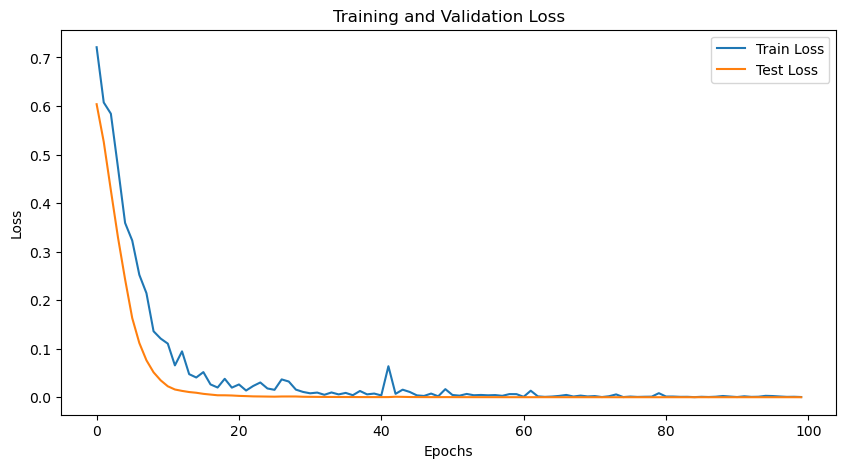

In [43]:
bcm = BinaryClassifierModel()

config = dict()
bcm.load_config(config)
X = df['vector'].to_list()
y = df['target'].to_list()
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
bcm.load_train_data(X, y)
bcm.load_val_data(X, y)
bcm.create_new_model()
bcm.train()

